In [2]:
#imporation des bibiotheques necessaires
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import imutils
import mahotas
import glob


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.metrics import accuracy_score

from sklearn.decomposition import KernelPCA,PCA,FactorAnalysis

from sklearn.manifold import Isomap,TSNE

import mahotas



from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split,learning_curve
from sklearn.model_selection import GridSearchCV

#ignore les messages d'erreurs
import warnings
warnings.filterwarnings('ignore')


# 1-Features Extraction

In [ ]:
#fonction qui extrait les caracteristique de la texture c.a.d les moments de Hu


def shapeFeatures(image):
    
    image = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2GRAY)
    
    shape = cv2.HuMoments(cv2.moments(image)).flatten()
    
    feature = -np.sign(shape) * np.log10(np.abs(shape))
    
    
    return feature

In [ ]:
#Texture using Haralick

def textureFeature(image):
    
    # convert the image to grayscale
    gray = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    features = mahotas.features.haralick(image.astype(np.uint8)).ravel()
    # return the result
    return features


In [ ]:
#Fonction qui cree une dataset contenant les caracteristiques des images de training

def createTrainFeatures(Folder):
    
    dataframe=pd.DataFrame() #dataframe global qui va stocker les caracteristique de chaque images
    
    
    #lister les sous dossiers contenues dans le dossier Folder
    for class_fold in glob.glob(Folder+"/*"):
        
        #Pour chaque sous-dossiers on liste liste les images "jpg" qu'il contient
        
        for imagePath in glob.glob(class_fold+ "/*.jpg"):
            
            #recupere le nom de l'image courant
            image = cv2.imread(imagePath) #lecture de l'image courant
            
            
            #moments=getMoments(image) #recupere le moments de l'image
            #hist=hsvHistogram(image) #recupere l'histogramme
            texture=textureFeature(image) 
            shape=shapeFeatures(image)
            
            #concatenation du vecteurs de moments avec l'histogramme dans un seul vecteur
            features=np.concatenate((texture,shape))
            
            #creation d'un dataframe contenant les caracteristique de chaque image avec le nom et l'id de sa classe
            df=pd.DataFrame([features])
            df["class_name"]=class_fold.split("\\")[1]
            
            
            #ajout du dataframe de l'image dans le dataframe globale
            dataframe=dataframe.append(df)
               
    
    dataframe.index=range(dataframe.index.size) #reorganise les index du dataframe
    
    return dataframe
dataset=createTrainFeatures("asl_alphabet_train")
dataset.head()


In [ ]:
#Fonction qui cree une dataset contenant les caracteristiques des images du test

def createTestFeatures(Folder):
    
    dataframe=pd.DataFrame() #dataframe global qui va stocker les caracteristique de chaque images
    
    #Pour chaque sous-dossiers on liste liste les images "jpg" qu'il contient
    
    for imagePath in glob.glob(Folder+ "/*.jpg"):
        
        #recupere le nom de l'image courant
        image = cv2.imread(imagePath) #lecture de l'image courant
            
            
        #moments=getMoments(image) #recupere le moments de l'image
        #hist=hsvHistogram(image) #recupere l'histogramme
        texture=textureFeature(image) 
        shape=shapeFeatures(image)
            
        #concatenation du vecteurs de moments avec l'histogramme dans un seul vecteur
        features=np.concatenate((shape,texture))
            
        #creation d'un dataframe contenant les caracteristique de chaque image avec le nom et l'id de sa classe
        df=pd.DataFrame([features])
        df["Image_name"]=imagePath.split("\\")[1]
            
            
        #ajout du dataframe de l'image dans le dataframe globale
        dataframe=dataframe.append(df)
               
    
    dataframe.index=range(dataframe.index.size) #reorganise les index du dataframe
    
    return dataframe

data_pred=createTestFeatures("asl_alphabet_test")
data_pred.head()


In [5]:
#separation des donnée 

X=dataset.drop(["class"],axis=1) #recuperation des variables d'entrées
Y=dataset["class"] #recupere les variables de sortie

In [6]:
#Standardisation des donnes
std_scaler=StandardScaler().fit(X.values)
X_std=std_scaler.transform(X.values)

In [7]:
X_train,X_test,Y_train,Y_test=train_test_split(X_std,Y,test_size=0.3,random_state=10)

# 2- Apprentissage

## KNN

In [8]:
knn=KNeighborsClassifier(n_neighbors=5,n_jobs=10)

knn.fit(X_train,Y_train)

y_pred_knn=knn.predict(X_test)

In [9]:
#Evaluation du modèle de classification

acc_knn=accuracy_score(Y_test,y_pred_knn) #accuracy
#mconf_knn=confusion_matrix(Y_test,y_pred_knn) #matrice de confusion

print("Accuracy Score KNN = ",acc_knn)
#print(classification_report(Y_test,y_pred_svm))

Accuracy Score KNN =  0.9839463601532568


## Decision Tree

In [10]:
tree=DecisionTreeClassifier(random_state=10)

tree.fit(X_train,Y_train)

y_pred_tree=tree.predict(X_test)


In [11]:
#Evaluation du modèle de classification

acc_tree=accuracy_score(Y_test,y_pred_tree) #accuracy

print("Accuracy Score Decision Tree = ",acc_tree)

Accuracy Score Decision Tree =  0.9327586206896552


## Random Forest

In [12]:

rf=RandomForestClassifier(n_jobs=10)
rf.fit(X_train,Y_train)

y_pred_rf=rf.predict(X_test)



In [11]:
acc_rf=accuracy_score(Y_test,y_pred_rf) #accuracy
print("Accuracy :",acc_rf)

Accuracy : 0.9911494252873563


## Model summary

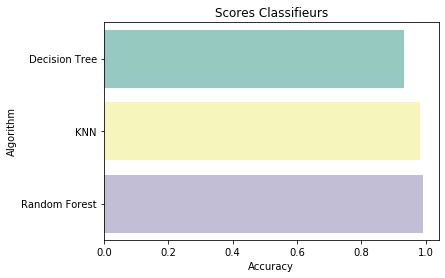

In [12]:
cv_res = pd.DataFrame({"Accuracies":[acc_tree,acc_knn,acc_rf],"Algorithm":['Decision Tree','KNN', 'Random Forest']})

g = sns.barplot("Accuracies","Algorithm",data = cv_res, palette="Set3")
g.set_xlabel("Accuracy")
g = g.set_title("Scores Classifieurs")

# 3- Features Selections

## Feature selection using Relief

In [13]:
from ReliefF import ReliefF

fs = ReliefF(n_neighbors=10, n_features_to_keep=100)

X_red = fs.fit_transform(X_std, Y.values)
print("(No. of tuples, No. of Columns before ReliefF) : "+str(X_std.shape)+
      "\n(No. of tuples, No. of Columns after ReliefF) : "+str(X_red.shape))

(No. of tuples, No. of Columns before ReliefF) : (87000, 176)
(No. of tuples, No. of Columns after ReliefF) : (87000, 100)


In [14]:
#split new data
X_train_fs,X_test_fs,Y_train_fs,Y_test_fs=train_test_split(X_red,Y,test_size=0.3,random_state=10)

### KNN

In [15]:
knn_fs=KNeighborsClassifier(n_neighbors=5,n_jobs=10)

knn_fs.fit(X_train_fs,Y_train_fs)

y_pred_knn_fs=knn_fs.predict(X_test_fs)

#Evaluation du modèle de classification

acc_knn_fs=accuracy_score(Y_test_fs,y_pred_knn_fs) #accuracy
#mconf_knn=confusion_matrix(Y_test,y_pred_knn) #matrice de confusion

print("Accuracy Score KNN = ",acc_knn_fs)

Accuracy Score KNN =  0.9909961685823755


### Decision Tree

In [17]:
tree_fs=DecisionTreeClassifier(random_state=10)

tree_fs.fit(X_train_fs,Y_train_fs)

y_pred_tree_fs=tree_fs.predict(X_test_fs)

#Evaluation du modèle de classification

acc_tree_fs=accuracy_score(Y_test_fs,y_pred_tree_fs) #accuracy
#mconf_knn=confusion_matrix(Y_test,y_pred_knn) #matrice de confusion

print("Accuracy Score Tree Decision ReliefF = ",acc_tree_fs)


Accuracy Score Tree Decision ReliefF =  0.9331034482758621


### Random Forest

In [18]:

rf_fs=RandomForestClassifier(n_jobs=10)
rf_fs.fit(X_train_fs,Y_train_fs)

y_pred_rf_fs=rf_fs.predict(X_test_fs)

acc_rf_fs=accuracy_score(Y_test_fs,y_pred_rf_fs) #accuracy
print("Accuracy Random Forest ReliefF :",acc_rf_fs)

Accuracy Random Forest ReliefF : 0.9906513409961686


# 3- Hyperparameter tuning & learning curves for selected classifiers

In [47]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt



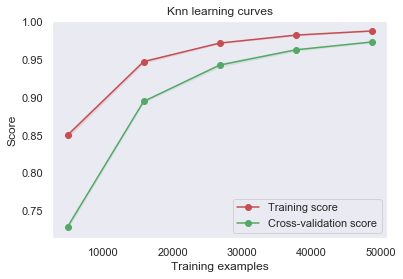

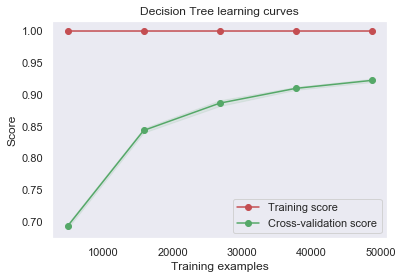

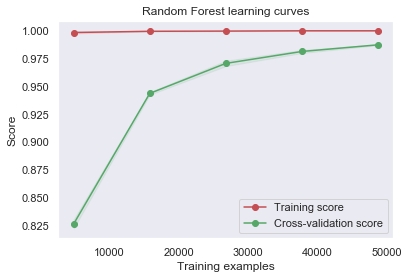

In [49]:
g = plot_learning_curve(knn,"Knn learning curves",X_train,Y_train,cv=5)
g = plot_learning_curve(tree,"Decision Tree learning curves",X_train,Y_train,cv=5)
g = plot_learning_curve(rf,"Random Forest learning curves",X_train,Y_train,cv=5)

# 4-Selecting and combining the best classifiers :
On va afficher le heatmaps de correlations des resulats des meilleurs classifieurs,et eliminer les classifieurs dont les predictions ne sont pas en correlations avec les autres.

In [19]:


test_TREE = pd.Series(y_pred_tree, name="Decision Tree")

test_KNN = pd.Series(y_pred_knn, name="KNN")

test_RF = pd.Series(y_pred_rf, name="Random_forest")



In [20]:
TREE=test_TREE.map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,
                     'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'del':26,'nothing':27,'space':28}).astype(int)

KNN=test_KNN.map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,
                     'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'del':26,'nothing':27,'space':28}).astype(int)
RF=test_RF.map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,
                     'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'del':26,'nothing':27,'space':28}).astype(int)

(3.0, 0.0)

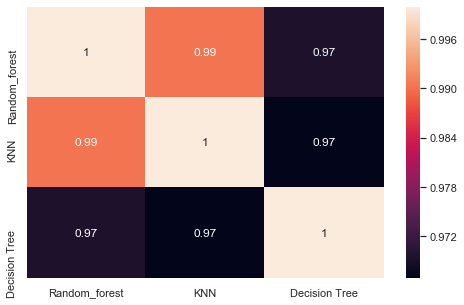

In [34]:
# Concatenate all classifier results
plt.figure(figsize=(8,5))
ensemble_results = pd.concat([RF,KNN,TREE],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)

# Ensembling


In [35]:
#on choisit les meilleurs classifierus et on fait une vote a la majorité sur les resultat 

VotingPredictor = VotingClassifier(estimators=[('KNN',knn), ('Random_forest',rf),('Decision Tree',tree)], weights=[2,1.5,1],
                                   voting='soft')

VotingPredictor = VotingPredictor.fit(X_train,Y_train)

#Ici on va donner les données de predictions
VotingPredictor_predictions = VotingPredictor.predict(X_test)




In [36]:
accu=accuracy_score(Y_test,VotingPredictor_predictions)
print("Accuracy : ",accu)

Accuracy :  0.9950191570881226


# Prediction des données de Test

In [37]:
#recuperation des features des images à predire
X_pred=data_pred.drop(["Image_name"],axis=1)


#standardisations
std_scal=StandardScaler().fit(X_pred.values)
X_pred=std_scal.transform(X_pred.values)




In [44]:
# Predictions des données de test
y_pred = VotingPredictor.predict(X_pred)

In [45]:
# Submit File 
#creation du fichiers csv

dic={"Name": data_pred["Image_name"].values,
    "Classe":y_pred}

df_result=pd.DataFrame(dic)
df_result
#df_result.to_csv("Prediction_SAID_ABDEREMANE.csv",index=False)

,Name,Classe
0,A_test.jpg,space
1,B_test.jpg,E
2,C_test.jpg,C
3,D_test.jpg,D
4,E_test.jpg,E
5,F_test.jpg,F
6,G_test.jpg,G
7,H_test.jpg,H
8,I_test.jpg,I
9,J_test.jpg,J


In [46]:
(15/20)*100

75.0